# A model workflow for IMEX_LavaFlow

IMEX_LavaFlow is a highly versatile liquid simulation model, with some specialized parameters for lava flow.

In [1]:
import rioxarray as rxr
import xarray as xr
import subprocess
import numpy as np  
import matplotlib.pyplot as plt
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import pyproj
import netCDF4
import sys
import shutil

In [2]:
sys.path.insert(0,"/home/jovyan/shared/Libraries")
import victor

In [ ]:
savefig = True

### In the following sections, we will provide a variety of input information, including topographical, rheological and thermal parameters.

### First, you must enter the run name, along with some time constraints and flags to determine the kind of output they would like to produce.

In [3]:
#prefix for output files
run_name = "MaunaLoa"

#starting a run from a previous output (T/F)
restart = 'F'

#Starting simulation time, recommended is 0
t_start = 0

#End simulation time
t_end = 20000

#Delta time between output snapshots
dt_output = 8000

#Flags for output of conservation, esri ascii DEM, 
# physical variables, and max runout at each dt (T/F)
cons, esri, phys, runout = 'F','T','T','F'

#Select verbose level (0 recommeneded)
verbose_level = 0

### Here the user sets the parameters for a radial source. Need to provide its location, size, lava velocity, temperature, and duration of effusion.

In [4]:
#UTM x coordinate
x_source=237215

#UTM y coordinate
y_source=2160775

#radius of source (km)
r_source=  20.0

#velocity source
vel_source= 8.40E-3

#temperatue(kelvin) source
t_source= 1538

#end and start time flux parameters
time_param= "50.0 , 50.0 , 0.0 , 50.0"

### Here, the user may input additional parameters to specify granularity of each cell

The current values are set to popular values at a reasonable granularity, though users are welcome to make changes.
Additional flags to incorporate more detailed parameters into the model are also offered here.

In [5]:
#set size of cells im m^2
cell_size = 30

#set x_0 and y_0 in UTM
x0, y0 = x_source-cell_size*20, y_source-cell_size*20

#set number of cells on x and y axes
cells_x, cells_y = 150, 200


#set flags for additional rheology, energy, and liquid information
rheo, energy, liquid = 'T', 'F', 'T'

#set additional flags for radial source, bottom radial source,
# collapsing volume, velocity profile, and temperature profile
radial, bottom_radial, collapsing, v_profile, temp_profile = 'F','T','F','T','F'


### Here, we provide a DEM and vent location check. 

The user can pick any DEM, but must have a file named *topography_dem.asc* **in this folder** when they finish inputting parameters or else the simulation will not run.

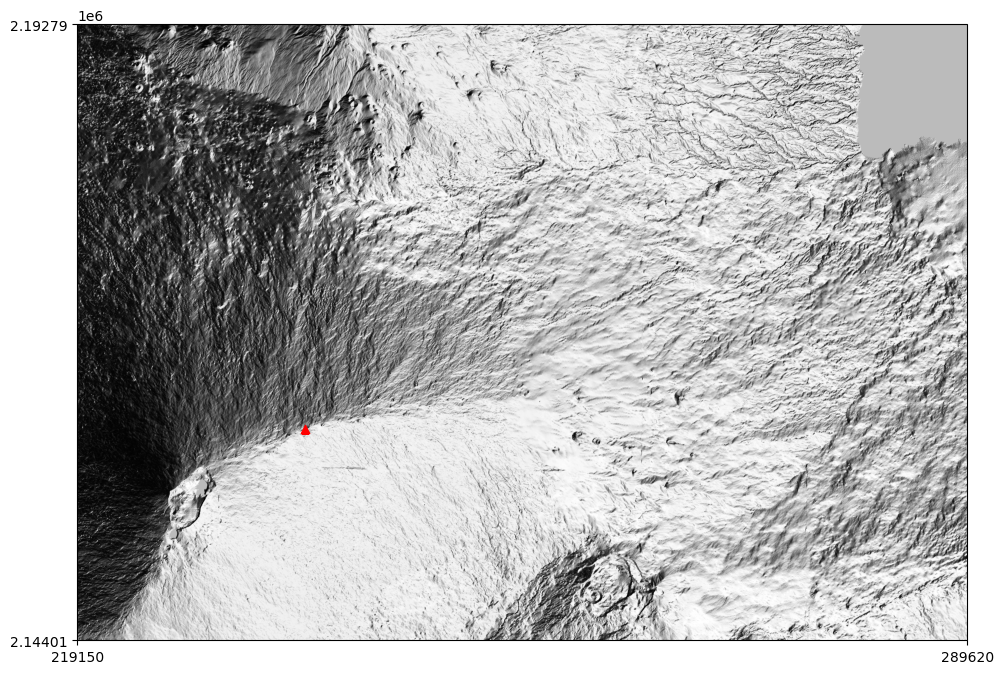

(2160175.0, 2166175.0)

In [6]:
dem = "/home/jovyan/shared/DEMs/MaunaLoa_30m_UTM5N.asc"
coordinates = np.array([x_source, y_source])
victor.plot_dem(dem,coordinates)
ax.set_xlim(x0, x0+cell_size*cells_x)
ax.set_ylim(y0, y0+cell_size*cells_y)


### Below, the user should enter thermal parameters for the lava.

In [22]:
#set emmisivity
emissivity = 0.80E0

#set atmospheric heat coefficient
atm_heat_transf_coeff = 70.0E0

#set expeted fraction of area
exp_area_fract = 0.50E0

#set specific heat capacity
c_p = 1150.0E0

#set enne value (viscous heating term)
enne = 4.0E0

#set temperature (in kelvin) of the environemnt
t_env = 300.0E0

#set temperature (in kelvin) of the ground
t_ground = 300.0E0 

#set thermal conductivity of the lava
thermal_conductivity_fluid = 4.0E0

#set thermal conductivity of the soil
thermal_conductivity_soil = 2.0E0

#set emme value (additional viscousity term)
emme = 12.0E0

#set density of the soil
rho_soil = 1250.0E0

#set specific heat of the soil
c_p_soil = 800.0E0

#set current temperature of the soil
t_soil = 300.0E0

### Below, set the numerical parameters. 

These parameters impact the stability of the solution, and should be handled carefully.

In [23]:
#Setting solver scheme (choose from LxF, GFORCE, KT)
#'LxF'       => lax-friedrichs scheme;
#'GFORCE '   => gforce scheme;
#'KT'        => Kurganov and Tadmor semidiscrete scheme;
solver_sceme = "\"KT\""

#set cfl (Courant-Friedrichs-Lewy parameter)
cfl = .24

#set limiter (for the slope in the linear reconstruction)
limiter = "3*1"

#set slope coeffiecient for the linear reconstruction
reconstr_coeff = 1

### Gravity in $m/s^2$. Change if running for another planet or moon.

In [23]:
#set gravity (in case of non terran modeling)
grav = 9.81

### Below, the user should enter rheological parameters

We provide convenient defaults, though these values can and should be changed.

In [24]:
#set model used (1=Voellmy-Salm,2=plastic,3=using reference kinematic viscosity, viscosity param,yield strength (nu_ref/visc_par/tau0),
#4=simplified with fewer params  5=Kurganov & Petrova,6=Bursik * Woods)
rheology_model = 3

#viscosity parameter [K-1]
visc_par = 1.00E-3

#reference kinematic viscosity [m2/s]
nu_ref = 0.0380E0

#reference temperature [K]
t_ref = 1538.0E0

#yield strength for lava rheology [kg m-1 s-2]
tau0 = 750.0E0

### Please enter parameters for gas, useful in a degassing situation.

In [1]:
#Specific heat of air (units: J K-1 kg-1)
sp_heat_a = 998

#Specific gas constant of air (units: J kg-1 K-1)
sp_gas_const_a = 287.051

#Kinematic viscosity of air (units: m2 s-1) (10^-5 scale)
kin_visc_a = 1.48

#Kinematic viscosity of air (units: m2 s-1)
pres = 101300

#Kinematic viscosity of air (units: m2 s-1)
t_ambient = 300

### The next three cells can be run without further input. 

We have set up the correct input format and will run the model for you. Please wait until the final of the three cells completes, with a `CompletedProcess` output, to continue.

In [26]:
the_rest = f'''&RUN_PARAMETERS
 RUN_NAME="{run_name}",
 RESTART={restart},
 T_START=  {t_start}     ,
 T_END=  {t_end},
 DT_OUTPUT=  {dt_output},
 OUTPUT_CONS_FLAG={cons},
OUTPUT_ESRI_FLAG = {esri} ,

 OUTPUT_PHYS_FLAG={phys},
 OUTPUT_RUNOUT_FLAG={runout},
 VERBOSE_LEVEL={verbose_level},
 /
&NEWRUN_PARAMETERS
 X0={x0}.0D0,
 Y0=  {y0}.0D0     ,
 COMP_CELLS_X=  {cells_x},
 COMP_CELLS_Y=  {cells_y},	
 CELL_SIZE = {cell_size}.D0    ,
 RHEOLOGY_FLAG = {rheo} ,
 ENERGY_FLAG = {energy},
 LIQUID_FLAG = {liquid}, 
 RADIAL_SOURCE_FLAG = {radial},
 COLLAPSING_VOLUME_FLAG = {collapsing} ,
 BOTTOM_RADIAL_SOURCE_FLAG = {bottom_radial},
 VELOCITY_PROFILE_FLAG = {v_profile},
 TEMPERATURE_PROFILE_FLAG = {temp_profile},
 /
&WEST_BOUNDARY_CONDITIONS
 H_BCW%FLAG=          1,
 H_BCW%VALUE=  0.0000000000000000     ,
 HU_BCW%FLAG=          1,
 HU_BCW%VALUE=  0.0000000000000000     ,
 HV_BCW%FLAG=          1,
 HV_BCW%VALUE=  0.0000000000000000     ,
 T_BCW%FLAG=          1,
 T_BCW%VALUE=  0.0000000000000000     ,
 /
&EAST_BOUNDARY_CONDITIONS
 H_BCE%FLAG=          1,
 H_BCE%VALUE=  0.0000000000000000     ,
 HU_BCE%FLAG=          1,
 HU_BCE%VALUE=  0.0000000000000000     ,
 HV_BCE%FLAG=          1,
 HV_BCE%VALUE=  0.0000000000000000     ,
 T_BCE%FLAG=          1,
 T_BCE%VALUE=  0.0000000000000000     ,
 /
&SOUTH_BOUNDARY_CONDITIONS
 H_BCS%FLAG=          1,
 H_BCS%VALUE=  0.0000000000000000     ,
 HU_BCS%FLAG=          1,
 HU_BCS%VALUE=  0.0000000000000000     ,
 HV_BCS%FLAG=          1,
 HV_BCS%VALUE=  0.0000000000000000     ,
 T_BCS%FLAG=          1,
 T_BCS%VALUE=  0.0000000000000000     ,
 /
&NORTH_BOUNDARY_CONDITIONS
 H_BCN%FLAG=          1,
 H_BCN%VALUE=  0.0000000000000000     ,
 HU_BCN%FLAG=          1,
 HU_BCN%VALUE=  0.0000000000000000     ,
 HV_BCN%FLAG=          1,
 HV_BCN%VALUE=  0.0000000000000000     ,
 T_BCN%FLAG=          1,
 T_BCN%VALUE=  0.0000000000000000     ,
 /
&TEMPERATURE_PARAMETERS
 EMISSIVITY = {emissivity} ,
 ATM_HEAT_TRANSF_COEFF = {atm_heat_transf_coeff}
 EXP_AREA_FRACT = {exp_area_fract} ,
 C_P = {c_p},
 ENNE = {enne} ,
 T_ENV = {t_env} ,
 T_GROUND = {t_ground} ,
 THERMAL_CONDUCTIVITY_FLUID = {thermal_conductivity_fluid} , 
 THERMAL_CONDUCTIVITY_SOIL = {thermal_conductivity_soil} ,
 EMME = {emme},
 RHO_SOIL = {rho_soil} ,
 C_P_SOIL = {c_p_soil},
 T_SOIL = {t_soil} , 
 /
&NUMERIC_PARAMETERS
 SOLVER_SCHEME={solver_sceme},
 DT0 = 1.0E-2
 MAX_DT=  10.0000000000000000E-000,
 CFL= {cfl},
 LIMITER= {limiter},
 THETA=  1.300000000000000     ,
 RECONSTR_COEFF=  {reconstr_coeff},
 N_RK= 2,
 /
&EXPL_TERMS_PARAMETERS
 GRAV= {grav},
 /
&RHEOLOGY_PARAMETERS
 RHEOLOGY_MODEL = {rheology_model},
 VISC_PAR = {visc_par},
 NU_REF = {nu_ref} ,
 T_REF = {t_ref},
 TAU0 = {tau0} ,
 /
&RADIAL_SOURCE_PARAMETERS
 X_SOURCE=  {x_source}.0D0 ,
 Y_SOURCE=   {y_source}.0D0 ,
 R_SOURCE=  {r_source}D0     ,
 VEL_SOURCE= {vel_source},
 T_SOURCE= {t_source}.D0     ,   ,
 TIME_PARAM= {time_param}  ,
 /
&GAS_TRANSPORT_PARAMETERS
 SP_HEAT_A = {sp_heat_a}.D0 ,
 SP_GAS_CONST_A = {sp_gas_const_a}D0 ,
 KIN_VISC_A = {kin_visc_a}D-5 ,
 PRES = {pres}.D0 ,
 T_AMBIENT = {t_ambient}.D0 ,
 /
&LIQUID_TRANSPORT_PARAMETERS
 SP_HEAT_L = 1150.D0 ,
 RHO_L = 2600.D0 ,
 /
 '''

In [27]:
f = open("IMEX_LavaFlow.inp",'w')
f.write(the_rest)
f.close()

Now we run the Model! Please note: If the models finishes very quickly it is likely spitting out an error mesage. comment out the last parameter to see what comes out oun STDOUT. 

In [30]:
subprocess.run("./IMEX_LavaFlow", shell=True,stdout=subprocess.DEVNULL)

CompletedProcess(args='./IMEX_LavaFlow', returncode=0)

### Now that everything has run, we have a variety of outputs to utilize. 

The cell below will explain the options and allow you to select a timestep and choose between temperature and flow depth.

In [7]:
num_times = int(np.ceil(t_end/dt_output)+1)
print("Based on the end time and intervals given, there are",num_times,"timesteps available to visualize, starting at 0 (0-"+str(num_times-1)+"). Please enter a number below.")

Based on the end time and intervals given, there are 4 timesteps available to visualize, starting at 0 (0-3). Please enter a number below.


### After entering a number in the valid range, run the rest of the cells.

After a few moments, you will see two plots displaying flow depth and temperature profiles at the given time. Additionally, two neatly formatted netCDF files with the full time series will be output to the current folder.

In [19]:
step = "2"

In [20]:
time_series = []
time_series_temp = []
for i in range(num_times):
    steps = str(i)
    steps = steps.zfill(4)
    filename = "./"+run_name
    filename_temp = "./"+run_name
    filename += "_"+steps+".asc"
    filename_temp += "_T"+"_"+steps+".asc"
    time_series.append(rxr.open_rasterio(filename).drop('band')[0])
    time_series_temp.append(rxr.open_rasterio(filename).drop('band')[0])

In [22]:
step = step.zfill(4)
filename = "./"+run_name
filename_temp = "./"+run_name
filename += "_"+step+".asc"
filename_temp += "_T"+"_"+step+".asc"

In [13]:
times = xr.concat(time_series,dim="time")
times_temp = xr.concat(time_series_temp,dim="time")
ds = times.to_dataset(name='elevation')
ds_temp = times_temp.to_dataset(name='temperature')
ds.to_netcdf("IMEX.nc")
ds.close()
ds_temp.to_netcdf("IMEX_temp.nc")
ds_temp.close()
subprocess.run("rm *.p_2d", shell=True)

Text(0.5, 1.0, 'IMEX Temperature')

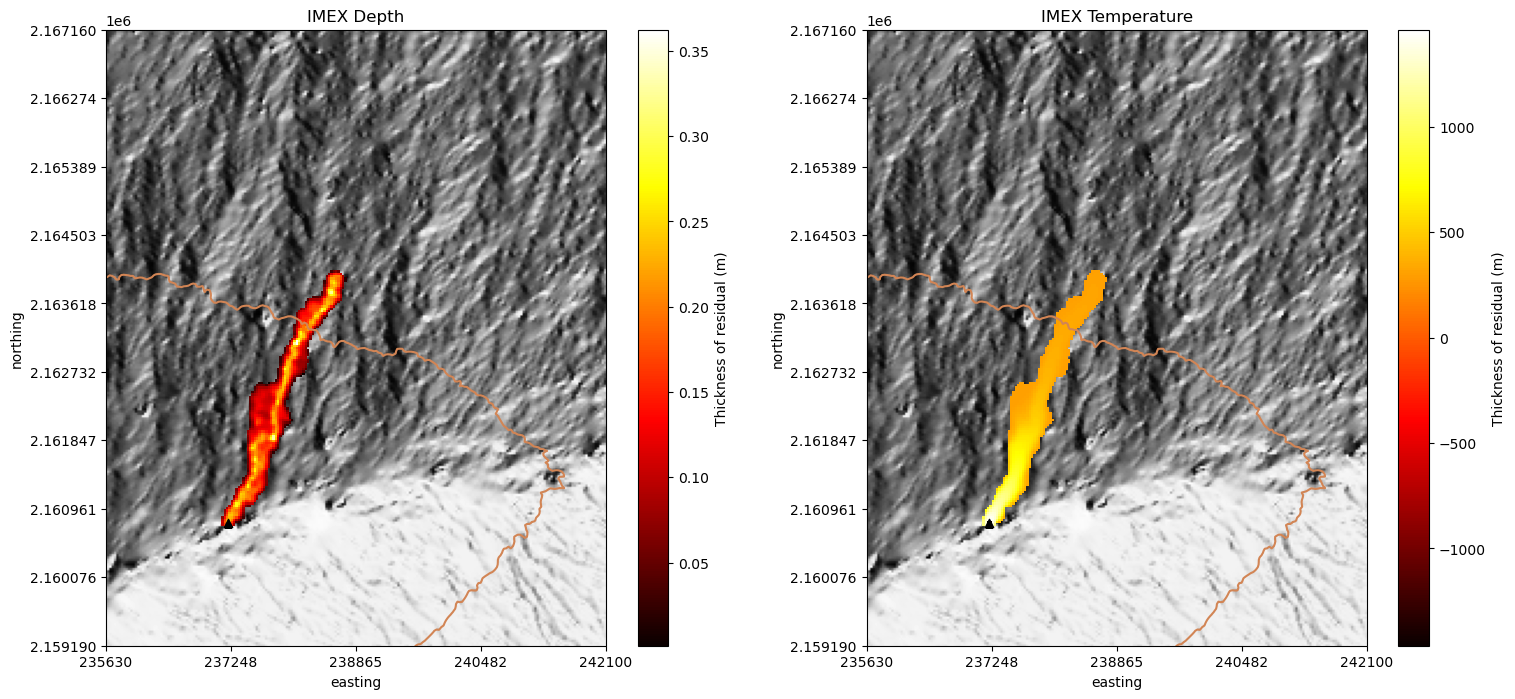

In [23]:
fig, (axd, axt) = plt.subplots(1,2, figsize=(18,8),subplot_kw=dict(projection=ccrs.epsg(32628)))

victor.plot_flow(dem, filename, axes=axd, coords=coordinates)

axd.set_title("IMEX Depth")

victor.plot_flow(dem, filename_temp, fig, axes=axt, coords=coordinates,label="Temperature of source")

axt.set_title("IMEX Temperature")

if savefig:
    plt.savefig("IMEX.svg")